# FL experiment with FairFed

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import tomllib as tl

from model import network
from declearn.quickrun import quickrun

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import shuffle
from aif360.sklearn.datasets import fetch_adult

/Users/martina/Desktop/fairfed-experiment/.venv/lib/python3.11/site-packages/declearn/model/tensorflow/utils/_gpu.py:71: UserWarning: Cannot use a GPU device: either CUDA is unavailable or no GPU is visible to tensorflow.
  warnings.warn(


In [2]:
with open("config.toml", "rb") as f:
    config = tl.load(f)

data_dir = config["data"]["data_folder"]
num_clients = len(config["data"]["client_names"])

## Dataset

In [3]:
def get_numerical_dataset():
    """
    Import the Adult Income Dataset
    """
    X, y, sample_weights = fetch_adult(dropna=False)

    # # Shuffle the dataset
    X, y, sample_weights = shuffle(X, y, sample_weights, random_state=42)

    # Transform sex into binary value
    # 0 if Female, 1 if Male
    X["sex"] = (X["sex"] == "Male").astype(int)

    # Encode other features
    le = LabelEncoder()
    for column in X.columns:
        if X[column].dtype != np.float64 and X[column].dtype != np.int64:
            X[column] = le.fit_transform(X[column])

    y = le.fit_transform(y)

    return X, y

In [4]:
def manage_protected_attributes(X, y, sensitive_attributes):
    """
    Saves and removes the protected attributes from the dataset

    Input:
    - `X`: features
    - `y`: labels
    - `sensitive_attributes`: list of sensitive attributes to remove from the dataset

    Output:
    - `X`: features without the protected attributes
    - `y`: labels
    - `protected_attribute_values`: the values of the protected attributes
    - `privileged`: the set of privileged groups
    """

    protected_attribute_values = X["sex"].values
    groups = set(protected_attribute_values)
    privileged_groups = {1}

    # remove protected attributes from features
    for sensitive_attribute in sensitive_attributes:
        if sensitive_attribute in X.columns:
            X = X.drop(columns=[sensitive_attribute])

    return X, y, protected_attribute_values, privileged_groups

In [5]:
def split_dataset(X, y, test_size=0.3):
    """
    Split the dataset into training and testing sets

    Input:
    - `X`: features
    - `y`: labels
    - `test_size`: the size of the testing set, expressed as a percentage of the dataset (default: 0.2)

    Output:
    - `X_train`: training features
    - `y_train`: training labels
    - `X_test`: testing features
    - `y_test`: testing labels
    """

    features = X.values
    labels = y

    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(features)

    # Convert features and labels to correct data types
    X_scaled = X_scaled.astype(np.float32)
    y = labels.astype(np.int32)

    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=test_size, shuffle=False
    )

    return X_train, y_train, X_test, y_test

Import dataset and encode features, manage protected attributes, and split train and test sets

In [6]:
X, y = get_numerical_dataset()
X, y, protected_attribute_values, _ = manage_protected_attributes(X, y, ["sex", "race"])
X_train, y_train, X_test, y_test = split_dataset(X, y)

In [7]:
def create_client_data_no_cov_same_size(
    features, labels, protected_attribute_values, num_clients: int
):
    client_data = []
    client_size = features.shape[0] // num_clients

    for i in range(num_clients):
        client_features = features[i * client_size : (i + 1) * client_size]
        client_labels = labels[i * client_size : (i + 1) * client_size]
        client_protected_values = protected_attribute_values[
            i * client_size : (i + 1) * client_size
        ]

        # Count the number of examples for each class and associate it as metadata
        client_metadata = {
            f"{label}": count
            for label, count in enumerate(np.bincount(client_protected_values))
        }
        client_data.append(
            (client_features, client_labels, client_protected_values, client_metadata)
        )

    return client_data

In [8]:
client_train_data = create_client_data_no_cov_same_size(
    X_train, y_train, protected_attribute_values, num_clients
)

client_test_data = create_client_data_no_cov_same_size(
    X_test, y_test, protected_attribute_values, num_clients
)

Save client data to the adult folder, creating a subdirectory for each client

In [9]:
for client in range(num_clients):

    # Create directory for each client
    client_dir = f"client_{client}"

    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    if not os.path.exists(f"{data_dir}/{client_dir}"):
        os.makedirs(f"{data_dir}/{client_dir}")

    # Save the data
    features, labels, _, _ = client_train_data[client]
    np.save(f"{data_dir}/{client_dir}/train_data.npy", features)
    np.save(f"{data_dir}/{client_dir}/train_target.npy", labels)

    features, labels, _, _ = client_test_data[client]
    np.save(f"{data_dir}/{client_dir}/valid_data.npy", features)
    np.save(f"{data_dir}/{client_dir}/valid_target.npy", labels)

## Model

In [10]:
network.summary()  # network is a `tensorflow.keras.Model` instance

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 929 (3.63 KB)

 Trainable params: 929 (3.63 KB)

 Non-trainable params: 0 (0.00 B)

## Run experiment

In [11]:
await quickrun(config="config.toml")

2025-02-03 11:21:51,773:Server:INFO: Server is now starting...
2025-02-03 11:21:51,778:Server:INFO: server listening on 127.0.0.1:8765
2025-02-03 11:21:51,778:Server:INFO: Starting clients registration process.
2025-02-03 11:21:52,786:Server:INFO: connection open
2025-02-03 11:21:52,788:Server:INFO: New connection from ('127.0.0.1', 56733)
2025-02-03 11:21:52,789:Server:INFO: connection open
2025-02-03 11:21:52,790:Server:INFO: New connection from ('127.0.0.1', 56734)
2025-02-03 11:21:52,791:Server:INFO: connection open
2025-02-03 11:21:52,792:Server:INFO: New connection from ('127.0.0.1', 56735)
2025-02-03 11:21:52,793:Server:INFO: connection open
2025-02-03 11:21:52,795:Server:INFO: New connection from ('127.0.0.1', 56736)
2025-02-03 11:21:52,796:Server:INFO: connection open
2025-02-03 11:21:52,797:Server:INFO: New connection from ('127.0.0.1', 56737)
2025-02-03 11:21:52,800:Server:INFO: Registering client 'client_0' for training.
2025-02-03 11:21:52,801:Server:INFO: Registering clie

## Results

In [12]:
res = pd.read_csv("results/server/metrics.csv")
res.head()

,timestamp,accuracy,loss
0,25-02-03_11-22-01,0.760819,0.533849
1,25-02-03_11-22-05,0.760819,0.482921
2,25-02-03_11-22-10,0.760819,0.456027
3,25-02-03_11-22-15,0.760819,0.438237
4,25-02-03_11-22-20,0.760819,0.425546


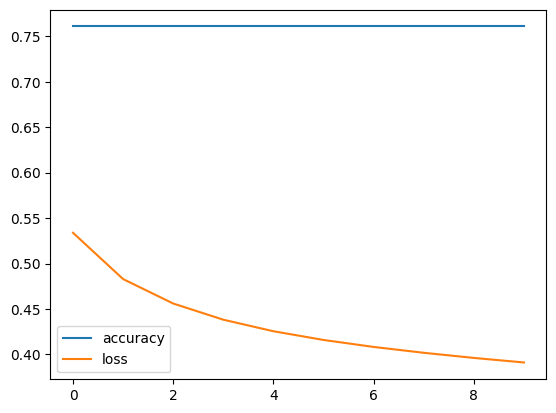

In [13]:
res_fig = res.plot()